# OATH Data Profiling and Visualization

This notebook loads the featurized OATH data and generates census tract level map renderings for all violation types.

## Setup and Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add src directory to path so we can import renderer
src_path = Path('../src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Import renderer function
from renderer import render_census_blocks_map

# Set display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

print("Imports successful!")

Imports successful!


## Load Data from All Subdirectories

In [8]:
# Define base path
base_path = Path('../data/processed/featurize')

# Load all datasets
datasets = {}

for subdir in ['annual', 'monthly', 'overall']:
    data_file = base_path / subdir / 'data.csv'
    if data_file.exists():
        print(f"Loading {subdir} data...")
        datasets[subdir] = pd.read_csv(data_file)
        print(f"  - Loaded {len(datasets[subdir]):,} records")
        print(f"  - Columns: {list(datasets[subdir].columns)}")
        print()
    else:
        print(f"Warning: {data_file} not found")

print(f"\nLoaded {len(datasets)} datasets: {list(datasets.keys())}")

Loading annual data...
  - Loaded 4,651 records
  - Columns: ['fips', 'year', 'oath_bike_on_sidewalk', 'oath_illegal_scooter', 'oath_public_drinking', 'oath_public_urination', 'oath_smoking_in_park', 'oath_unlicensed_vendor', 'oath_vendor_in_illegal_spot']

Loading monthly data...
  - Loaded 23,140 records
  - Columns: ['fips', 'year_month', 'oath_bike_on_sidewalk', 'oath_illegal_scooter', 'oath_public_drinking', 'oath_public_urination', 'oath_smoking_in_park', 'oath_unlicensed_vendor', 'oath_vendor_in_illegal_spot']

Loading overall data...
  - Loaded 1,924 records
  - Columns: ['fips', 'oath_bike_on_sidewalk', 'oath_illegal_scooter', 'oath_public_drinking', 'oath_public_urination', 'oath_smoking_in_park', 'oath_unlicensed_vendor', 'oath_vendor_in_illegal_spot']


Loaded 3 datasets: ['annual', 'monthly', 'overall']


## Inspect Annual Data

In [9]:
# Focus on annual data for mapping
annual_df = datasets['annual']

print("Annual Data Overview:")
print(f"Shape: {annual_df.shape}")
print(f"\nFirst few rows:")
annual_df.head()

Annual Data Overview:
Shape: (4651, 9)

First few rows:


,fips,year,oath_bike_on_sidewalk,oath_illegal_scooter,oath_public_drinking,oath_public_urination,oath_smoking_in_park,oath_unlicensed_vendor,oath_vendor_in_illegal_spot
0,36005000200,2023,0,0,8,0,0,0,0
1,36005000200,2024,0,0,2,1,0,0,0
2,36005000200,2025,0,0,4,0,0,0,0
3,36005000400,2023,0,0,4,0,0,0,0
4,36005000400,2024,0,0,1,0,0,0,0


In [ ]:
# Check data types and missing values
print("Data Info:")
annual_df.info()

print("\n" + "="*80)
print("Summary Statistics:")
print("="*80)
annual_df.describe()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4651 entries, 0 to 4650
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   fips                         4651 non-null   int64
 1   year                         4651 non-null   int64
 2   oath_bike_on_sidewalk        4651 non-null   int64
 3   oath_illegal_scooter         4651 non-null   int64
 4   oath_public_drinking         4651 non-null   int64
 5   oath_public_urination        4651 non-null   int64
 6   oath_smoking_in_park         4651 non-null   int64
 7   oath_unlicensed_vendor       4651 non-null   int64
 8   oath_vendor_in_illegal_spot  4651 non-null   int64
dtypes: int64(9)
memory usage: 327.2 KB

Summary Statistics:


,fips,year,oath_bike_on_sidewalk,oath_illegal_scooter,oath_public_drinking,oath_public_urination,oath_smoking_in_park,oath_unlicensed_vendor,oath_vendor_in_illegal_spot
count,4.651000e+03,4651.000000,4651.000000,4651.000000,4651.000000,4651.000000,4651.000000,4651.000000,4651.000000
mean,3.605209e+10,2024.021071,1.732961,0.979574,25.042786,4.000860,1.056547,1.161686,0.685874
std,2.507906e+07,0.810673,11.326136,7.964964,84.382137,16.369983,8.355156,8.164102,14.364293
min,3.600500e+10,2023.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.604702e+10,2023.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,3.604710e+10,2024.000000,0.000000,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000
75%,3.608101e+10,2025.000000,1.000000,0.000000,18.000000,3.000000,0.000000,0.000000,0.000000
max,3.608503e+10,2025.000000,525.000000,251.000000,1715.000000,577.000000,239.000000,223.000000,703.000000


In [ ]:
# Get list of violation columns (all columns except fips and year)
violation_columns = [col for col in annual_df.columns if col not in ['fips', 'year']]

print(f"Found {len(violation_columns)} violation types:")
for i, col in enumerate(violation_columns, 1):
    total = annual_df[col].sum()
    print(f"  {i}. {col}: {total:,} total violations")

Found 7 violation types:
  1. oath_bike_on_sidewalk: 8,060 total violations
  2. oath_illegal_scooter: 4,556 total violations
  3. oath_public_drinking: 116,474 total violations
  4. oath_public_urination: 18,608 total violations
  5. oath_smoking_in_park: 4,914 total violations
  6. oath_unlicensed_vendor: 5,403 total violations
  7. oath_vendor_in_illegal_spot: 3,190 total violations


Annual data from 2023 to 2025
Total years: 3


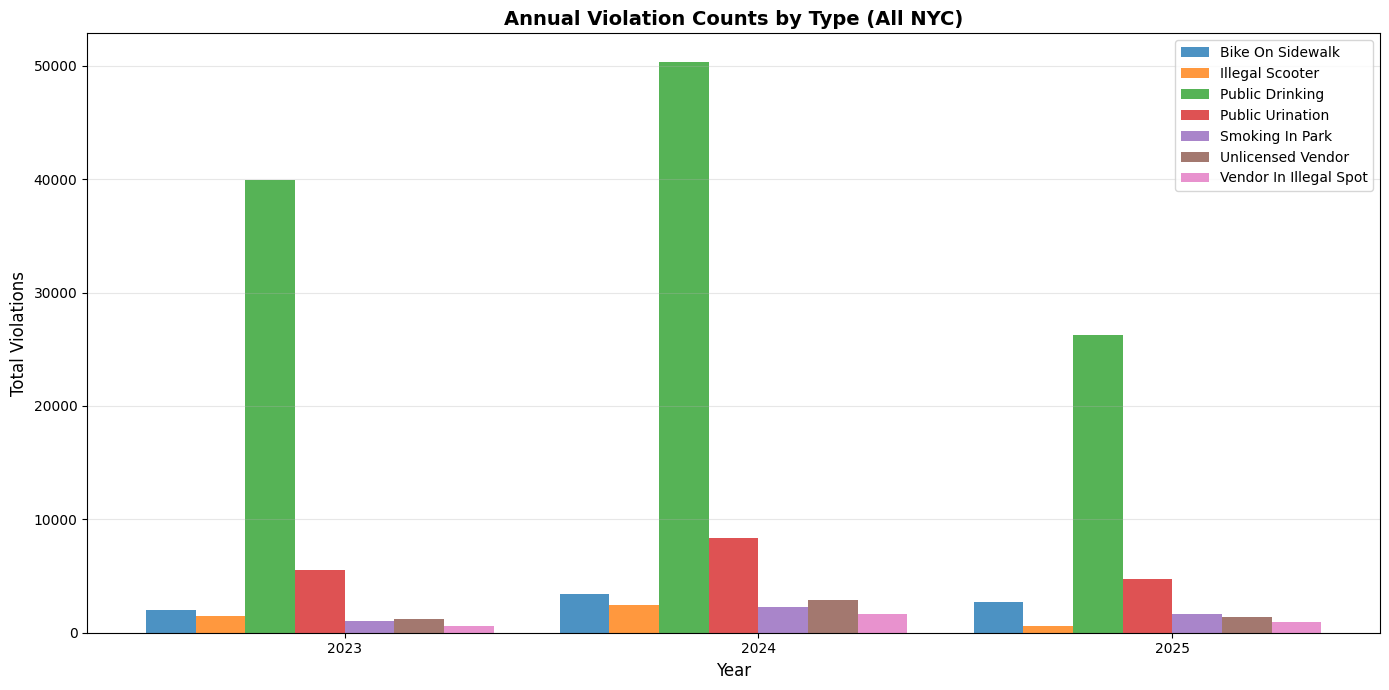


Annual trends plotted successfully!


In [13]:
# Annual violations over time
# Aggregate by year (sum across all FIPS codes)
annual_agg = annual_df.groupby('year')[violation_columns].sum().reset_index()

# Sort by year
annual_agg = annual_agg.sort_values('year')

print(f"Annual data from {annual_agg['year'].min()} to {annual_agg['year'].max()}")
print(f"Total years: {len(annual_agg)}")

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Set bar width and positions
x = annual_agg['year']
width = 0.12
positions = np.arange(len(x))

for i, col in enumerate(violation_columns):
    label = col.replace('oath_', '').replace('_', ' ').title()
    offset = (i - len(violation_columns)/2) * width
    ax.bar(positions + offset, annual_agg[col], width=width, label=label, alpha=0.8)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Violations', fontsize=12)
ax.set_title('Annual Violation Counts by Type (All NYC)', fontsize=14, fontweight='bold')
ax.set_xticks(positions)
ax.set_xticklabels(annual_agg['year'])
ax.legend(loc='best', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nAnnual trends plotted successfully!")

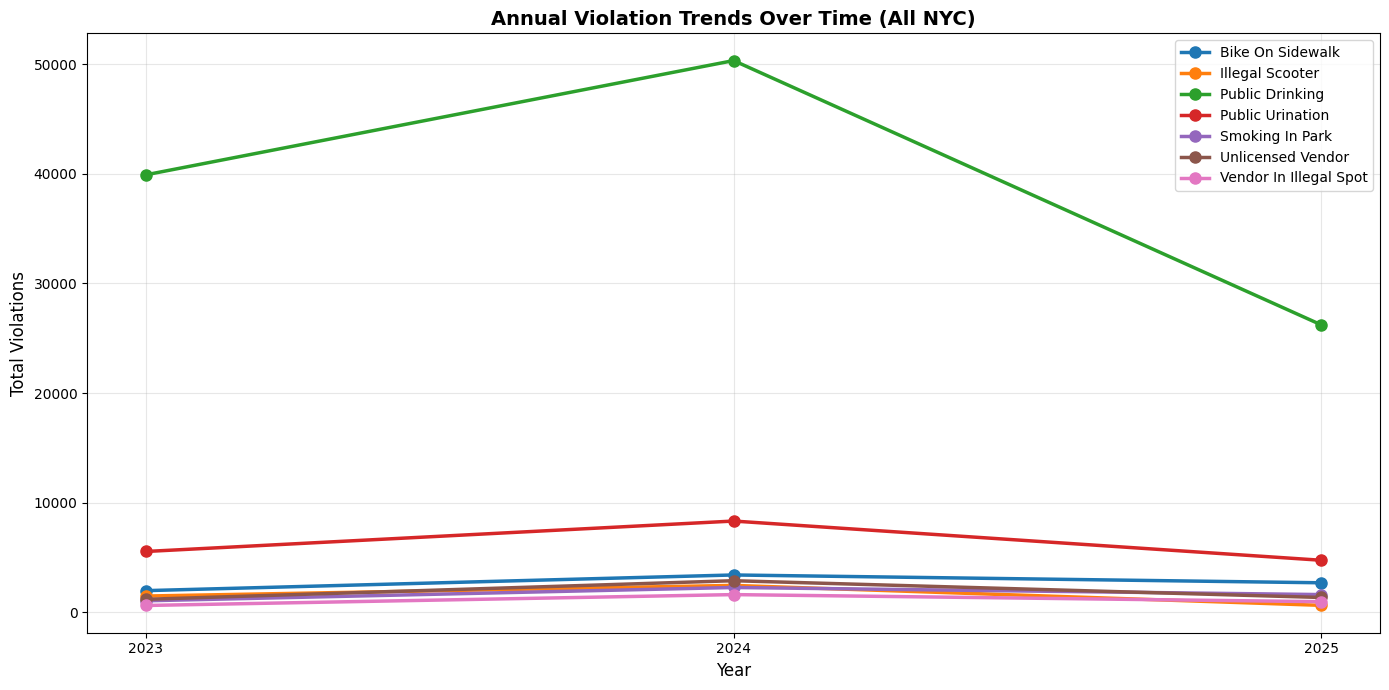


Annual line plot complete!


In [14]:
# Annual violations - line plot alternative
fig, ax = plt.subplots(figsize=(14, 7))

for col in violation_columns:
    label = col.replace('oath_', '').replace('_', ' ').title()
    ax.plot(annual_agg['year'], annual_agg[col], marker='o', label=label, linewidth=2.5, markersize=8)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Violations', fontsize=12)
ax.set_title('Annual Violation Trends Over Time (All NYC)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(annual_agg['year'])
plt.tight_layout()
plt.show()

print("\nAnnual line plot complete!")

Monthly data from 2023-01-01 00:00:00 to 2025-09-01 00:00:00
Total months: 33


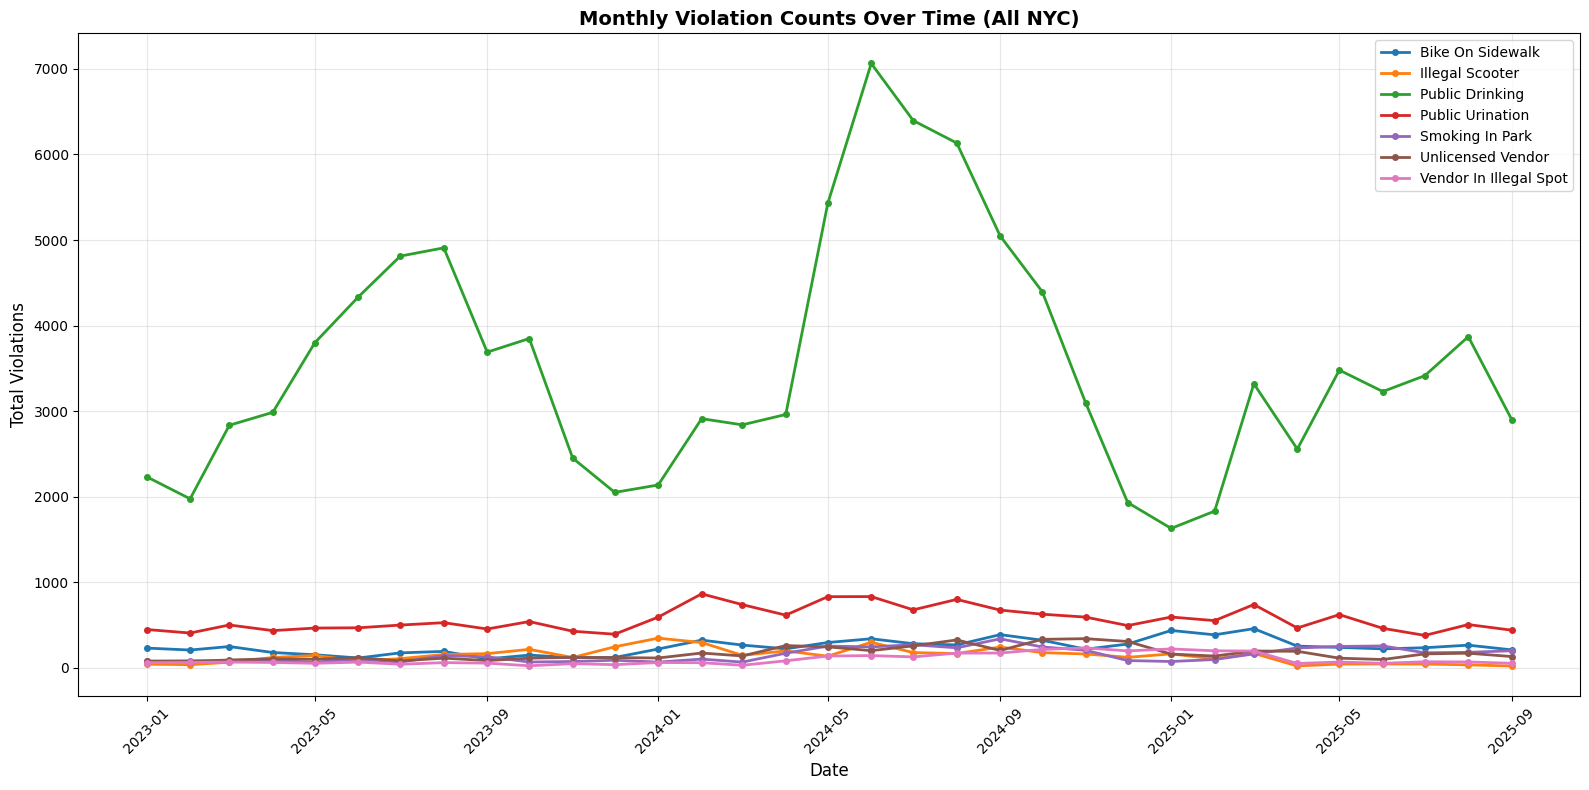


Monthly trends plotted successfully!


In [15]:
# Monthly violations over time
monthly_df = datasets['monthly'].copy()

# Convert year_month to datetime for plotting
monthly_df['date'] = pd.to_datetime(monthly_df['year_month'])

# Aggregate by month (sum across all FIPS codes)
monthly_agg = monthly_df.groupby('date')[violation_columns].sum().reset_index()

# Sort by date
monthly_agg = monthly_agg.sort_values('date')

print(f"Monthly data from {monthly_agg['date'].min()} to {monthly_agg['date'].max()}")
print(f"Total months: {len(monthly_agg)}")

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

for col in violation_columns:
    label = col.replace('oath_', '').replace('_', ' ').title()
    ax.plot(monthly_agg['date'], monthly_agg[col], marker='o', label=label, linewidth=2, markersize=4)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Violations', fontsize=12)
ax.set_title('Monthly Violation Counts Over Time (All NYC)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nMonthly trends plotted successfully!")

## Aggregate Data by FIPS for Mapping

Sum violations across all years for each census tract.

In [ ]:
# Aggregate by FIPS (sum across all years)
print("Aggregating data by FIPS code (summing across all years)...")

# Group by fips and sum all violation columns
agg_data = annual_df.groupby('fips')[violation_columns].sum().reset_index()

# Ensure fips is integer type
agg_data['fips'] = agg_data['fips'].astype('Int64')

print(f"\nAggregated data shape: {agg_data.shape}")
print(f"Number of unique FIPS codes: {agg_data['fips'].nunique():,}")
print(f"\nFirst few rows:")
agg_data.head(10)

Aggregating data by FIPS code (summing across all years)...

Aggregated data shape: (1924, 8)
Number of unique FIPS codes: 1,924

First few rows:


,fips,oath_bike_on_sidewalk,oath_illegal_scooter,oath_public_drinking,oath_public_urination,oath_smoking_in_park,oath_unlicensed_vendor,oath_vendor_in_illegal_spot
0,36005000200,0,0,14,1,0,0,0
1,36005000400,0,1,6,0,0,0,0
2,36005001600,0,0,4,0,0,1,0
3,36005001901,0,0,6,1,0,0,0
4,36005001902,1,0,27,7,0,1,0
5,36005001903,0,0,7,2,0,0,0
6,36005002001,1,0,69,11,2,0,0
7,36005002002,1,0,56,10,0,0,0
8,36005002300,4,0,44,7,0,0,0
9,36005002400,0,0,3,4,0,0,0


In [ ]:
annual_df.year.unique()

array([2023, 2024, 2025])

## Create Output Directory for Maps

In [ ]:
# Create output directory for maps
output_dir = Path('../data/processed/maps')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Maps will be saved to: {output_dir.resolve()}")

Maps will be saved to: /Users/thatcher/dev/analysis/projects/oath/data/processed/maps


## Generate Census Tract Level Maps for All Violation Types

This will create a map for each violation type showing the distribution across NYC census tracts.

In [ ]:
# Generate maps for each violation column
print("Generating census tract maps for all violation types...\n")
print("="*80)

years = annual_df.year.unique()
counter = 0
for violation_col in violation_columns:
    for year in years:
        counter += 1
        print(f"\n[{counter}/{len(violation_columns) * len(years)}] Generating map for: {violation_col} in {year}")
        print("-"*80)
        
        # Create a clean title from column name
        title = violation_col.replace('oath_', '').replace('_', ' ').title()
        
        # Define output file
        output_file = output_dir / f"{violation_col}_{year}_map.png"
        if output_file.exists():
            print("Map already generated, skipping...")
            continue
        
        df = annual_df[annual_df['year'] == year]
        # Statistics for this violation
        total = df[violation_col].sum()
        non_zero = (df[violation_col] > 0).sum()
        max_val = df[violation_col].max()
        
        print(f"  Total violations: {total:,}")
        print(f"  Census tracts with violations: {non_zero:,}")
        print(f"  Max violations in single tract: {max_val:,}")
        
        # Generate the map
        try:
            render_census_blocks_map(
                output_file=str(output_file),
                figsize=(12, 10),
                dpi=150,
                census_tracts=True,
                choropleth_data=df,
                value_column=violation_col,
                fips_column='fips',
                colormap='YlOrRd',
                legend_title=title
            )
            print(f"  ✓ Map saved to: {output_file.name}")
        except Exception as e:
            print(f"  ✗ Error generating map: {e}")
        
        # Close plot to free memory
        plt.close('all')

print("\n" + "="*80)
print(f"\nAll maps generated! Check the output directory: {output_dir.resolve()}")

Generating census tract maps for all violation types...


[1/21] Generating map for: oath_bike_on_sidewalk in 2023
--------------------------------------------------------------------------------
  Total violations: 1,971
  Census tracts with violations: 333
  Max violations in single tract: 235
Loading census block shapefile...
Loaded 288819 census blocks
Coordinate system: EPSG:4269
Filtering out water only blocks...
Filtered to 281108 census blocks
Filtering to counties: {'061', '005', '047', '085', '081'}
Filtered to 37380 census blocks
Dissolving blocks into census tracts...
Created 1529 census tracts
Applying choropleth coloring using oath_bike_on_sidewalk from choropleth data...
Matched 896 of 1529 geometries with choropleth data
Saving map to ../data/processed/maps/oath_bike_on_sidewalk_2023_map.png...
Map rendering complete!
  ✓ Map saved to: oath_bike_on_sidewalk_2023_map.png

[2/21] Generating map for: oath_bike_on_sidewalk in 2024
-------------------------------------------

## Summary Statistics by Violation Type

In [ ]:
# Create summary table
summary_data = []

for col in violation_columns:
    summary_data.append({
        'Violation Type': col.replace('oath_', '').replace('_', ' ').title(),
        'Column Name': col,
        'Total Violations': int(agg_data[col].sum()),
        'Tracts with Violations': int((agg_data[col] > 0).sum()),
        'Max in Single Tract': int(agg_data[col].max()),
        'Mean per Tract': float(agg_data[col].mean()),
        'Median per Tract': float(agg_data[col].median())
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Total Violations', ascending=False)

print("\nSummary Statistics by Violation Type:")
print("="*80)
summary_df


Summary Statistics by Violation Type:


,Violation Type,Column Name,Total Violations,Tracts with Violations,Max in Single Tract,Mean per Tract,Median per Tract
2,Public Drinking,oath_public_drinking,116474,1776,3118,60.537422,12.0
3,Public Urination,oath_public_urination,18608,1279,847,9.671518,1.0
0,Bike On Sidewalk,oath_bike_on_sidewalk,8060,761,602,4.189189,0.0
5,Unlicensed Vendor,oath_unlicensed_vendor,5403,399,388,2.808212,0.0
4,Smoking In Park,oath_smoking_in_park,4914,363,508,2.554054,0.0
1,Illegal Scooter,oath_illegal_scooter,4556,571,393,2.367983,0.0
6,Vendor In Illegal Spot,oath_vendor_in_illegal_spot,3190,115,1245,1.658004,0.0


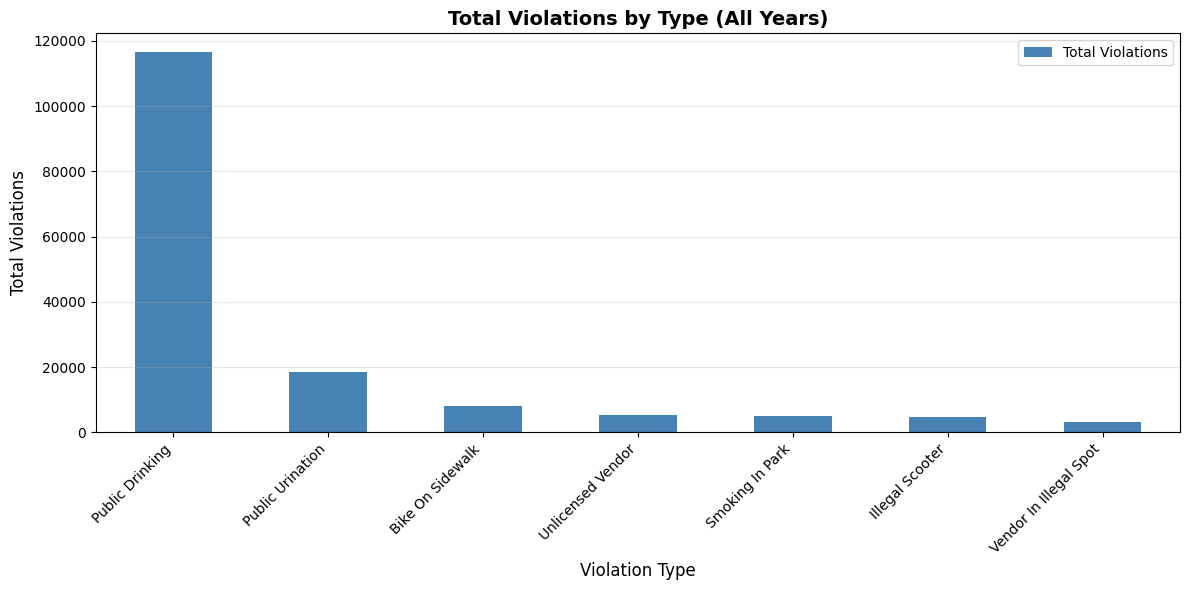


Summary chart saved to: ../data/processed/maps/total_violations_by_type.png


In [ ]:
# Bar chart of total violations by type
fig, ax = plt.subplots(figsize=(12, 6))

summary_df.plot(x='Violation Type', y='Total Violations', kind='bar', ax=ax, color='steelblue')
ax.set_xlabel('Violation Type', fontsize=12)
ax.set_ylabel('Total Violations', fontsize=12)
ax.set_title('Total Violations by Type (All Years)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(output_dir / 'total_violations_by_type.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSummary chart saved to: {output_dir / 'total_violations_by_type.png'}")

## Export Summary Table

In [ ]:
# Export summary to CSV
summary_file = output_dir / 'violation_summary.csv'
summary_df.to_csv(summary_file, index=False)
print(f"Summary table exported to: {summary_file}")

Summary table exported to: ../data/processed/maps/violation_summary.csv
